In [1]:
# Kaggle brain tumor Image Classification (MRI) - Kaggle 뇌종양(Brain Tumor) 이미지 분류, 512x512

# MobileNet(pre-trained model) -> GlobalAveragePooling(Flatten Layer) -> relu -> relu -> softmax
# 학습데이터 개수가 3,000개 정도로서 매우 부족하기 때문에 Transfer Learning 사용함

In [2]:
# 라이브러리
import os
import shutil
import random
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [3]:
# ===============================
# 데이터 경로 설정
# ===============================
ROOT_DIR = '.\\data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

In [4]:
# 압축 해제
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'brain_tumor.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [5]:
# ===============================
# Dataset 준비
# ===============================
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# transforms 설정
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# datasets.ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DATA_ROOT_DIR, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 정답 label
class_names = train_dataset.classes
print('클래스 : ', class_names)

클래스 :  ['glioma', 'meningioma', 'notumor', 'pituitary']


torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329]

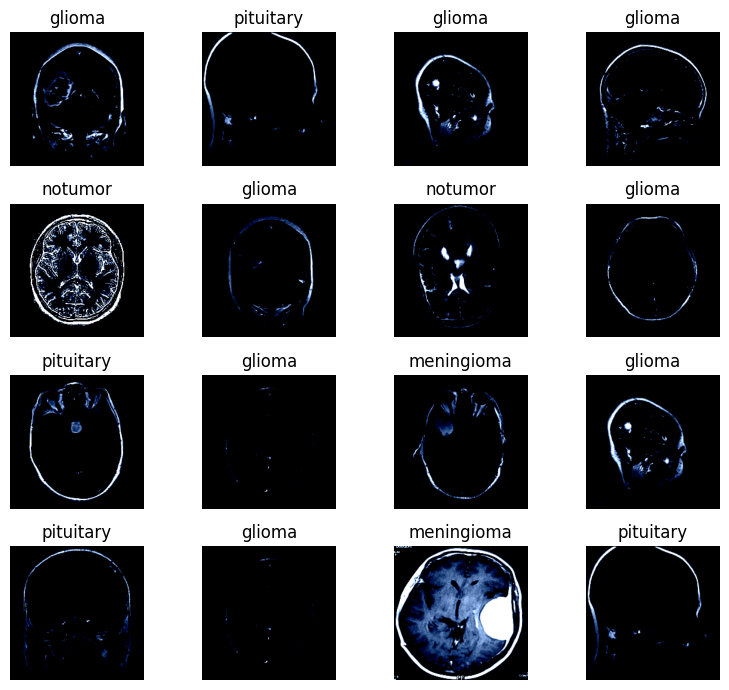

In [6]:
# 1개 배치 추출
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드
print(model)
print('------------------------------')
print(model.last_channel)
print('------------------------------')
print(model.classifier[1].in_features)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
# ===============================
# 모델 정의 (MobileNetV2)
# ===============================
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드

# nn.Sequential() 구조로 설계
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, 512), # 마지막 입력값(in_features=1280)을 가져오는 코드 - model.last_channel or model.classifier[1].in_features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, len(class_names)),
    nn.Softmax(dim=1)
)

model = model.to(DEVICE)

In [9]:
# ===============================
# 손실함수 & 옵티마이저
# ===============================
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [10]:
# ===============================
# 학습 함수
# ===============================
def train_model(model, loss_function, optimizer, train_loader, val_loader, num_epochs=50, patience=5):
    best_loss = np.inf
    counter = 0
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # 미분 초기화
            outputs = model(inputs) # 모델 예측
            loss = loss_function(outputs, labels) # 손실함수 계산

            _, preds = torch.max(outputs, 1) # 예측값 분리
            loss.backward() # 미분 연산
            optimizer.step() # 미분 연산 후 파라미터(가중치, 바이어스) 업데이트

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실함수값
        epoch_acc = running_corrects.double() / len(train_loader.dataset) # 평균 정확도값
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): # 오차역전파 사용 안함, 미분 연산 하지 않음
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # 모델 예측
                loss = loss_function(outputs, labels) # 손실함수값 계산

                _, preds = torch.max(outputs, 1) # 예측값 분리
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset) # validation 평균 손실함수값
        val_acc = val_running_corrects.double() / len(val_loader.dataset) # validation 평균 정확도값
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(best_model_wts)
                break

    return model, (train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

In [ ]:
# ===============================
# 학습 실행
# ===============================
model, history = train_model(model, loss_function, optimizer, train_loader, test_loader, num_epochs=50)

Epoch 1/50 - Train loss: 1.2252, acc: 0.5739 Val loss: 1.0057, acc: 0.7468
Epoch 2/50 - Train loss: 0.9206, acc: 0.8522 Val loss: 0.8671, acc: 0.8772
Epoch 3/50 - Train loss: 0.8154, acc: 0.9379 Val loss: 0.8070, acc: 0.9375
Epoch 4/50 - Train loss: 0.7872, acc: 0.9631 Val loss: 0.7867, acc: 0.9603
Epoch 5/50 - Train loss: 0.7738, acc: 0.9732 Val loss: 0.7764, acc: 0.9695


In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_transfer_learning_brain_tumor_mri.ckpt')

In [ ]:
# ===============================
# 테스트 성능 평가
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.70%


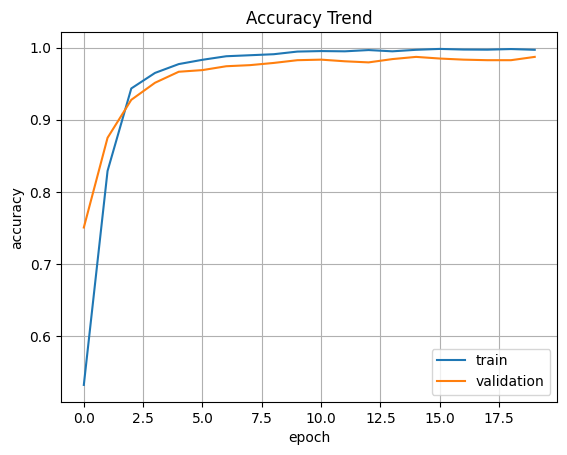

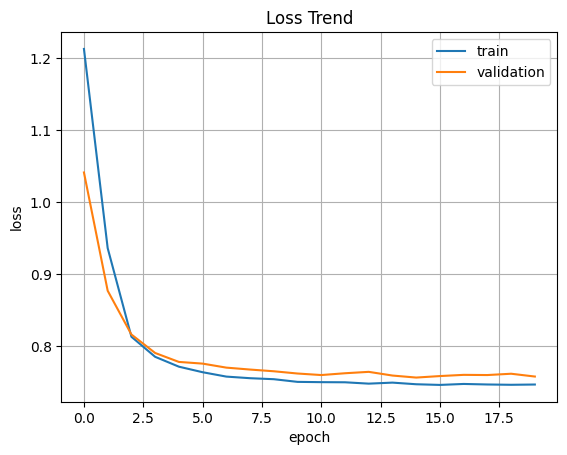

In [ ]:
# ===============================
# 성능 시각화
# ===============================
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = history

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()